**This is an experiment to test:**
1) whether an estimated SNR for an audio sample merged with background noise matches the actual SNR used in the sample generation;
2) the threshold SNR value with which wav2vec2 can generate text with an acceptable error rate.

The experiment was run using two audio samples and its transcripts. The samples were merged with the hallway background noise in ten different SNRs: -30, -20, -10, -5, 0, 5, 10, 15, 20, 30

In [30]:
from IPython.display import Audio, display

%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks'

display(Audio('LJSpeech-1.1/wavs/LJ012-0055.wav', rate=22050))
# 'LJSpeech-1.1/wavs/LJ016-0289.wav' "as day broke the character of the crowd was betrayed"
# 'LJSpeech-1.1/wavs/LJ012-0055.wav' "while there he was joined by his wife and other friends"

/home/studio-lab-user/sagemaker-studiolab-notebooks


In [ ]:
!pip install scikit-learn
!pip install seaborn

In [1]:
import numpy as np
import seaborn as sns
import librosa
import pandas as pd
import jiwer
import matplotlib.pyplot as plt
import torch
import torchaudio


from sklearn.linear_model import LinearRegression
from IPython.display import Audio, display

In [28]:
# Function to estimate SNR
# Calculated as the mean of the signal array divided by the standard deviation
# https://www.codespeedy.com/calculate-signal-to-noise-ratio-in-python/

def signaltonoise(a, axis=0, ddof=0):
    '''
    Input:
    a: array, containing the sample data
    axis: the axis along which the mean can be calculated; default = 0
    ddof: degree of freedom, which is a correction to the standard deviation, default = 0
    
    Output:
    array containing snr value
    '''
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd*1000)

In [30]:
import math
# Function to estimate SNR
# Calculated as the mean of the signal array divided by the standard deviation
# https://www.codespeedy.com/calculate-signal-to-noise-ratio-in-python/

def signaltonoise1(a, axis=0, ddof=0):
    '''
    Input:
    a: array, containing the sample data
    axis: the axis along which the mean can be calculated; default = 0
    ddof: degree of freedom, which is a correction to the standard deviation, default = 0
    
    Output:
    array containing snr value
    '''
    a = np.asanyarray(a)
    print(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    m_rs = math.sqrt(m**2)
    sd_rs = math.sqrt(sd**2)
    return np.where(sd_rs == 0, 0, 10*math.log10(m_rs/sd_rs))

In [6]:
def asr_evaluation(truth, performed):
    '''
    Input:
    
    truth: sample's transcripts (list of strings)
    performed: transcripts performed by the asr model (list of strings)
    
    
    Output:
    WER, CER, MER, and WIP scores
    '''
    
    ground_truths = truth
    hypothesis = performed
    
    print("Model: \n")
    
    wer_score = jiwer.wer(truth=ground_truths, hypothesis=hypothesis)
    print(f"Word Error Rate (WER) = {wer_score}")

    cer_score = jiwer.cer(truth=ground_truths, hypothesis=hypothesis)
    print(f"Character Error Rate (CER) = {cer_score}")
    
    mer_score = jiwer.mer(truth=ground_truths, hypothesis=hypothesis)
    print(f"Match Error Rate (MER) = {mer_score}")
    
    wip_score = jiwer.wip(truth=ground_truths, hypothesis=hypothesis)
    print(f"Word Information Preserved (WIP) = {wip_score}")

In [3]:
# Paths to signal wav files
signals = [
    'LJ007-0015_hallway_ch01snr30.wav',
    'LJ007-0015_hallway_ch01snr20.wav',
    'LJ007-0015_hallway_ch01snr15.wav',
    'LJ007-0015_hallway_ch01snr10.wav',
    'LJ007-0015_hallway_ch01snr5.wav',
    'LJ007-0015_hallway_ch01snr0.wav',
    'LJ007-0015_hallway_ch01snr-5.wav',
    'LJ007-0015_hallway_ch01snr-10.wav',
    'LJ007-0015_hallway_ch01snr-20.wav',
    'LJ007-0015_hallway_ch01snr-30.wav',
    'LJ048-0226_hallway_ch01snr30.wav',
    'LJ048-0226_hallway_ch01snr20.wav',
    'LJ048-0226_hallway_ch01snr15.wav',
    'LJ048-0226_hallway_ch01snr10.wav',
    'LJ048-0226_hallway_ch01snr5.wav',
    'LJ048-0226_hallway_ch01snr0.wav',
    'LJ048-0226_hallway_ch01snr-5.wav',
    'LJ048-0226_hallway_ch01snr-10.wav',
    'LJ048-0226_hallway_ch01snr-20.wav',
    'LJ048-0226_hallway_ch01snr-30.wav',
    'LJ012-0055_hallway_snr-30.wav',
    'LJ012-0055_hallway_snr-20.wav',
    'LJ012-0055_hallway_snr-10.wav',
    'LJ012-0055_hallway_snr-5.wav',
    'LJ012-0055_hallway_snr0.wav',
    'LJ012-0055_hallway_snr5.wav',
    'LJ012-0055_hallway_snr10.wav',
    'LJ012-0055_hallway_snr15.wav',
    'LJ012-0055_hallway_snr20.wav',
    'LJ012-0055_hallway_snr30.wav',
    'LJ016-0289_hallway_snr-30.wav',
    'LJ016-0289_hallway_snr-20.wav',
    'LJ016-0289_hallway_snr-10.wav',
    'LJ016-0289_hallway_snr-5.wav',
    'LJ016-0289_hallway_snr0.wav',
    'LJ016-0289_hallway_snr5.wav',
    'LJ016-0289_hallway_snr10.wav',
    'LJ016-0289_hallway_snr15.wav',
    'LJ016-0289_hallway_snr20.wav',
    'LJ016-0289_hallway_snr30.wav'
]

# Actual SNR
snr = [30, 20, 15, 10, 5, 0, -5, -10, -20, -30, 30, 20, 15, 10, 5, 0, -5, -10, -20, -30, -30, -20, -10, -5, 0, 5, 10, 15, 20, 30, -30, -20, -10, -5, 0, 5, 10, 15, 20, 30]

# Audio transcripts
transcripts = [
    "it had the bad effect of distracting attention",
    "it had the bad effect of distracting attention",
    "it had the bad effect of distracting attention",
    "it had the bad effect of distracting attention",
    "it had the bad effect of distracting attention",
    "it had the bad effect of distracting attention",
    "it had the bad effect of distracting attention",
    "it had the bad effect of distracting attention",
    "it had the bad effect of distracting attention",
    "it had the bad effect of distracting attention",
    "all of the agents stayed for a drink of beer or in several cases a mixed drink",
    "all of the agents stayed for a drink of beer or in several cases a mixed drink",
    "all of the agents stayed for a drink of beer or in several cases a mixed drink",
    "all of the agents stayed for a drink of beer or in several cases a mixed drink",
    "all of the agents stayed for a drink of beer or in several cases a mixed drink",
    "all of the agents stayed for a drink of beer or in several cases a mixed drink",
    "all of the agents stayed for a drink of beer or in several cases a mixed drink",
    "all of the agents stayed for a drink of beer or in several cases a mixed drink",
    "all of the agents stayed for a drink of beer or in several cases a mixed drink",
    "all of the agents stayed for a drink of beer or in several cases a mixed drink",
    "while there he was joined by his wife and other friends",
    "while there he was joined by his wife and other friends",
    "while there he was joined by his wife and other friends",
    "while there he was joined by his wife and other friends",
    "while there he was joined by his wife and other friends",
    "while there he was joined by his wife and other friends",
    "while there he was joined by his wife and other friends",
    "while there he was joined by his wife and other friends",
    "while there he was joined by his wife and other friends",
    "while there he was joined by his wife and other friends",
    "as day broke the character of the crowd was betrayed",
    "as day broke the character of the crowd was betrayed",
    "as day broke the character of the crowd was betrayed",
    "as day broke the character of the crowd was betrayed",
    "as day broke the character of the crowd was betrayed",
    "as day broke the character of the crowd was betrayed",
    "as day broke the character of the crowd was betrayed",
    "as day broke the character of the crowd was betrayed",
    "as day broke the character of the crowd was betrayed",
    "as day broke the character of the crowd was betrayed"
]

In [4]:
%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/snr_samples/en'

/home/studio-lab-user/sagemaker-studiolab-notebooks/snr_samples/en


In [9]:
# Calculate the estimated SNRs and store them in a list
snrs = []

for signal in signals:
    y, sr = librosa.load(signal)
    est_snr = signaltonoise(y)
    snrs.append(float(est_snr))

In [31]:
# Calculate the estimated SNRs and store them in a list
snrs = []

for signal in signals:
    y, sr = librosa.load(signal)
    est_snr = signaltonoise1(y)
    snrs.append(float(est_snr))
    print(signal, float(est_snr))


[ 1.5269025e-04  1.1239488e-04  5.4306965e-05 ... -3.3195482e-03
 -6.7763001e-04  0.0000000e+00]
LJ007-0015_hallway_ch01snr30.wav -35.05173296217438
[ 0.00043444  0.00033687  0.0003554  ... -0.01156727 -0.00272973
  0.        ]
LJ007-0015_hallway_ch01snr20.wav -28.535643122583842
[ 0.00075512  0.00059237  0.00069812 ... -0.02095496 -0.00506546
  0.        ]
LJ007-0015_hallway_ch01snr15.wav -25.82946138688252
[ 0.00132539  0.00104672  0.00130756 ... -0.03764888 -0.00921904
  0.        ]
LJ007-0015_hallway_ch01snr10.wav -23.337877640765477
[ 0.00233949  0.00185468  0.00239132 ... -0.06733532 -0.01660528
  0.        ]
LJ007-0015_hallway_ch01snr5.wav -21.166143608653655
[ 0.00414284  0.00329146  0.00431854 ... -0.12012611 -0.02974004
  0.        ]
LJ007-0015_hallway_ch01snr0.wav -19.555648852765422
[ 0.0073497   0.00584646  0.00774568 ... -0.2140029  -0.05309735
  0.        ]
LJ007-0015_hallway_ch01snr-5.wav -18.64562193083092
[ 0.0130524   0.01038997  0.01384009 ... -0.38094202 -0.0946331

In [10]:
# Create DataFrame
snr_df = pd.DataFrame(list(zip(signals, snrs, snr)),
               columns =['signal', 'estimated_snr', 'snr'])

snr_df.head(40)

,signal,estimated_snr,snr
0,LJ007-0015_hallway_ch01snr30.wav,-0.312483,30
1,LJ007-0015_hallway_ch01snr20.wav,-1.400992,20
2,LJ007-0015_hallway_ch01snr15.wav,-2.612485,15
3,LJ007-0015_hallway_ch01snr10.wav,-4.636735,10
4,LJ007-0015_hallway_ch01snr5.wav,-7.645144,5
5,LJ007-0015_hallway_ch01snr0.wav,-11.077330,0
6,LJ007-0015_hallway_ch01snr-5.wav,-13.659595,-5
7,LJ007-0015_hallway_ch01snr-10.wav,-14.945743,-10
8,LJ007-0015_hallway_ch01snr-20.wav,-15.617240,-20
9,LJ007-0015_hallway_ch01snr-30.wav,-15.698783,-30


In [11]:
# Get model
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()

In [12]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [14]:
# Run wav2vec2 and store generated text in a list

generated_text = []

for wav_file in signals:
    waveform, sample_rate = torchaudio.load(wav_file)
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000, resampling_method='sinc_interpolation')
    emission, _ = model(waveform)
    decoder = GreedyCTCDecoder(labels=bundle.get_labels())
    generated_text.append(decoder(emission[0]).replace('|', ' ').lower())

In [140]:
from sklearn import preprocessing

df = snr_df[['estimated_snr', 'snr']]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df)
df_normalized = pd.DataFrame(x_scaled, columns=['estimated_snr', 'snr'])
snr_df['z_est_snr'] = df_normalized['estimated_snr']
snr_df['z_snr'] = df_normalized['snr']
df_normalized.head(40)

,estimated_snr,snr
0,0.979169,1.000000
1,0.909898,0.833333
2,0.832799,0.750000
3,0.703978,0.666667
4,0.512526,0.583333
5,0.294105,0.500000
6,0.129772,0.416667
7,0.047923,0.333333
8,0.005189,0.166667
9,0.000000,0.000000


In [15]:
# Save the SNR values, generated text, and transcripts into the DataFrame
snr_df['generated_text'] = generated_text
snr_df['transcripts'] = transcripts

snr_df.head(40)

,signal,estimated_snr,snr,generated_text,transcripts
0,LJ007-0015_hallway_ch01snr30.wav,-0.312483,30,it had the bad effect of distracting attention,it had the bad effect of distracting attention
1,LJ007-0015_hallway_ch01snr20.wav,-1.400992,20,it had the bad effect of distracting attention,it had the bad effect of distracting attention
2,LJ007-0015_hallway_ch01snr15.wav,-2.612485,15,it had the bad effect of distracting attention,it had the bad effect of distracting attention
3,LJ007-0015_hallway_ch01snr10.wav,-4.636735,10,it had the bad effect of distracting attention,it had the bad effect of distracting attention
4,LJ007-0015_hallway_ch01snr5.wav,-7.645144,5,it had the bad effect of distracting attention,it had the bad effect of distracting attention
5,LJ007-0015_hallway_ch01snr0.wav,-11.077330,0,it had the bad effect of distracting attention,it had the bad effect of distracting attention
6,LJ007-0015_hallway_ch01snr-5.wav,-13.659595,-5,it had the bad effect of distracting attensione,it had the bad effect of distracting attention
7,LJ007-0015_hallway_ch01snr-10.wav,-14.945743,-10,had the bad jactwen to say act on a coe,it had the bad effect of distracting attention
8,LJ007-0015_hallway_ch01snr-20.wav,-15.617240,-20,that,it had the bad effect of distracting attention
9,LJ007-0015_hallway_ch01snr-30.wav,-15.698783,-30,,it had the bad effect of distracting attention


In [16]:
# Correlation between actual SNR and estimated SNR
snr_df['snr'].corr(snr_df['estimated_snr'])

0.5298311108786958

In [17]:
# Correlation between actual SNR and estimated SNR
df1 = snr_df[0:10]
df2 = snr_df[10:20]
df3 = snr_df[20:30]
df4 = snr_df[30:40]

corr1 = df1['snr'].corr(df1['estimated_snr'])
corr2 = df2['snr'].corr(df2['estimated_snr'])
corr3 = df3['snr'].corr(df3['estimated_snr'])
corr4 = df4['snr'].corr(df4['estimated_snr'])

print('correlation1: ', corr1)
print('correlation2: ', corr2)
print('correlation3: ', corr3)
print('correlation4: ', corr4)

correlation1:  0.9473684537010428
correlation2:  0.9435212915867263
correlation3:  0.9486723561863469
correlation4:  0.947217241197297


In [146]:
# Regression model predicting actual SNR from estimated SNR
snr_arr = snr_df['snr'].to_numpy()
est_snr_arr = snr_df['estimated_snr'].to_numpy().reshape((-1, 1))
r_model = LinearRegression().fit(est_snr_arr, snr_arr)
r_sq = r_model.score(est_snr_arr, snr_arr)
print('General')
print(f"R2: {r_sq}")
print(f"intercept: {r_model.intercept_}")
print(f"slope: {r_model.coef_}\n")

snr_arr1 = df1['snr'].to_numpy()
est_snr_arr1 = df1['estimated_snr'].to_numpy().reshape((-1, 1))
r_model1 = LinearRegression().fit(est_snr_arr1, snr_arr1)
r_sq1 = r_model1.score(est_snr_arr1, snr_arr1)
print(f"1: R2: {r_sq1}")
print(f"1: intercept: {r_model1.intercept_}")
print(f"1: slope: {r_model1.coef_}\n")

snr_arr2 = df2['snr'].to_numpy()
est_snr_arr2 = df2['estimated_snr'].to_numpy().reshape((-1, 1))
r_model2 = LinearRegression().fit(est_snr_arr2, snr_arr2)
r_sq2 = r_model2.score(est_snr_arr2, snr_arr2)
print(f"2: R2: {r_sq2}")
print(f"2: intercept: {r_model2.intercept_}")
print(f"2: slope: {r_model2.coef_}\n")

snr_arr3 = df3['snr'].to_numpy()
est_snr_arr3 = df3['estimated_snr'].to_numpy().reshape((-1, 1))
r_model3 = LinearRegression().fit(est_snr_arr3, snr_arr3)
r_sq3 = r_model3.score(est_snr_arr3, snr_arr3)
print(f"3: R2: {r_sq3}")
print(f"3: intercept: {r_model3.intercept_}")
print(f"3: slope: {r_model3.coef_}\n")

snr_arr4 = df4['snr'].to_numpy()
est_snr_arr4 = df4['estimated_snr'].to_numpy().reshape((-1, 1))
r_model4 = LinearRegression().fit(est_snr_arr4, snr_arr4)
r_sq4 = r_model4.score(est_snr_arr4, snr_arr4)
print(f"4: R2: {r_sq4}")
print(f"4: intercept: {r_model4.intercept_}")
print(f"4: slope: {r_model4.coef_}\n")

General
R2: 0.280721006054953
intercept: 9.226687579893197
slope: [2.13669548]

1: R2: 0.8975069870679051
1: intercept: 26.21024974984568
1: slope: [2.82059451]

2: R2: 0.890232427677484
2: intercept: 27.66273504872073
2: slope: [17.86175259]

3: R2: 0.8999792393921552
3: intercept: 24.991217883798427
3: slope: [11.26900026]

4: R2: 0.8972205020214186
4: intercept: 26.406476535767922
4: slope: [11.55877906]



General


<AxesSubplot: >

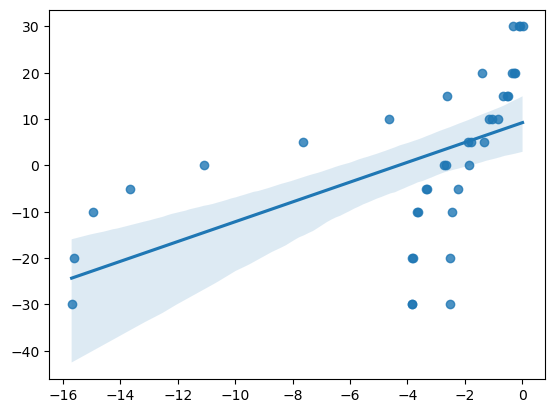

In [147]:
# Regression plot
print('General')
sns.regplot(x=est_snr_arr, y=snr_arr)

Sentence 1:


<AxesSubplot: >

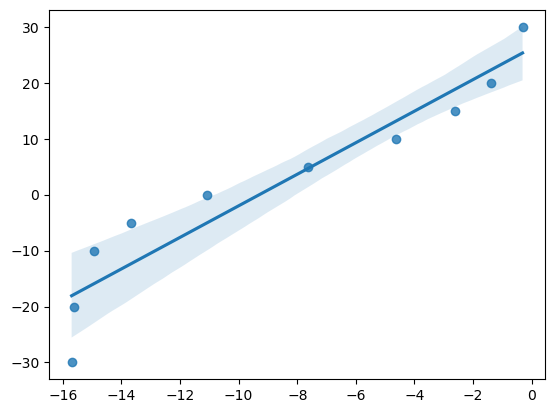

In [112]:
# Regression plot
print('Sentence 1:')
sns.regplot(x=est_snr_arr1, y=snr_arr1)

Sentence 2:


<AxesSubplot: >

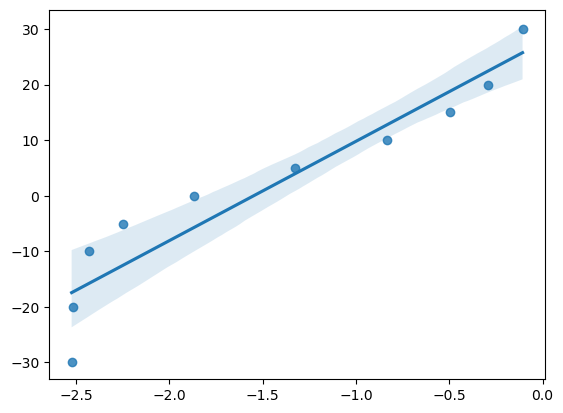

In [113]:
# Regression plot
print('Sentence 2:')
sns.regplot(x=est_snr_arr2, y=snr_arr2)

Sentence 3:


<AxesSubplot: >

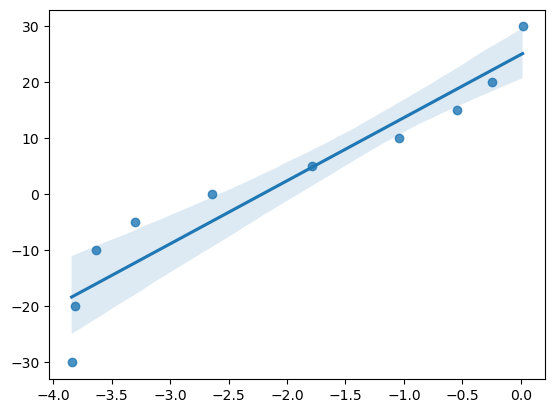

In [114]:
# Regression plot
print('Sentence 3:')
sns.regplot(x=est_snr_arr3, y=snr_arr3)

Sentence 4:


<AxesSubplot: >

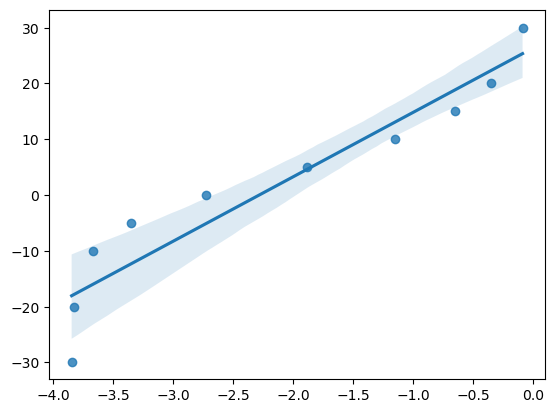

In [115]:
# Regression plot
print('Sentence 4:')
sns.regplot(x=est_snr_arr4, y=snr_arr4)

**The lower SNR values (greater amount of noise, poorer audio quality) seem to be harder to predict!** (in this small sample)

In [73]:
# Evaluate model performance

truth = transcripts
performed = generated_text
asr_evaluation(truth, performed)

Model: 

Word Error Rate (WER) = 0.3391304347826087
Character Error Rate (CER) = 0.24718614718614718
Match Error Rate (MER) = 0.33620689655172414
Word Information Preserved (WIP) = 0.5514066496163683


In [23]:
# Evaluate model performance
df1 = snr_df[0:10]
df2 = snr_df[10:20]
df3 = snr_df[20:30]
df4 = snr_df[30:40]

print('\nSentence 1:')
truth = list(df1['transcripts'])
performed = list(df1['generated_text'])
asr_evaluation(truth, performed)
      
print('\nSentence 2:')
truth = list(df2['transcripts'])
performed = list(df2['generated_text'])
asr_evaluation(truth, performed)

print('\nSentence 3:')
truth = list(df3['transcripts'])
performed = list(df3['generated_text'])
asr_evaluation(truth, performed)
      
print('\nSentence 4:')
truth = list(df4['transcripts'])
performed = list(df4['generated_text'])
asr_evaluation(truth, performed)


Sentence 1:
Model: 

Word Error Rate (WER) = 0.3125
Character Error Rate (CER) = 0.25217391304347825
Match Error Rate (MER) = 0.30120481927710846
Word Information Preserved (WIP) = 0.6276119402985074

Sentence 2:
Model: 

Word Error Rate (WER) = 0.3
Character Error Rate (CER) = 0.21794871794871795
Match Error Rate (MER) = 0.3
Word Information Preserved (WIP) = 0.5784722222222222

Sentence 3:
Model: 

Word Error Rate (WER) = 0.2818181818181818
Character Error Rate (CER) = 0.24
Match Error Rate (MER) = 0.27927927927927926
Word Information Preserved (WIP) = 0.6324110671936759

Sentence 4:
Model: 

Word Error Rate (WER) = 0.49
Character Error Rate (CER) = 0.29423076923076924
Match Error Rate (MER) = 0.49
Word Information Preserved (WIP) = 0.3663380281690141


In [29]:
print(df3[['snr','estimated_snr']])
print()
for i in list(df3['generated_text']):
    print(i)

    snr  estimated_snr
20  -30      -3.842937
21  -20      -3.818279
22  -10      -3.637029
23   -5      -3.302346
24    0      -2.643438
25    5      -1.783086
26   10      -1.039841
27   15      -0.544386
28   20      -0.249375
29   30       0.014842


while o oat be 
while there he was going to i his wain ay an crim 
while there he was joyfying his wife and ia friends 
while there he was joined by his wife and other friends 
while there he was joined by his wife and other friends 
while there he was joined by his wife and other friends 
while there he was joined by his wife and other friends 
while there he was joined by his wife and other friends 
while there he was joined by his wife and other friends 


In [74]:
# Model evaluation for each sentence
wer = []
cer = []
mer = []
wip = []

for i in range(len(truth)):
    wer.append(jiwer.wer(truth=truth[i], hypothesis=performed[i]))
    cer.append(jiwer.cer(truth=truth[i], hypothesis=performed[i]))
    mer.append(jiwer.mer(truth=truth[i], hypothesis=performed[i]))
    wip.append(jiwer.wip(truth=truth[i], hypothesis=performed[i]))

In [116]:
# Save sentence's scores to the dataframe
snr_df['wer'] = wer
snr_df['cer'] = cer
snr_df['mer'] = mer
snr_df['wip'] = wip
snr_df.to_csv('snr_experiment.csv', encoding='utf-8')

df1 = snr_df[0:10]
df2 = snr_df[10:20]
df3 = snr_df[20:30]
df4 = snr_df[30:40]

Text(0, 0.5, 'Performance Scores')

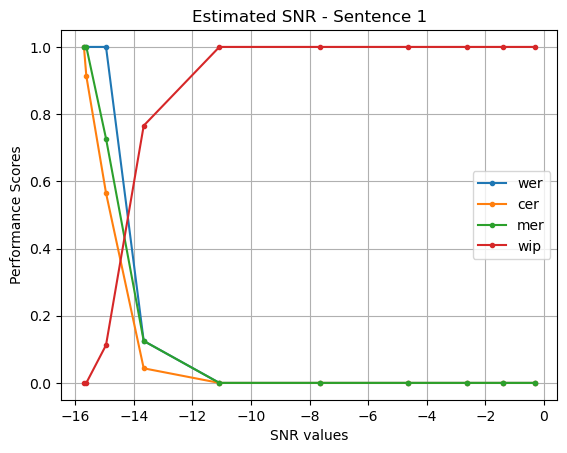

In [118]:
# Plot estimated SNR

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

df1 = df1.sort_values('estimated_snr', ascending = False)
ax1 = df1.plot(x='estimated_snr', y=['wer', 'cer', 'mer', 'wip'], grid=True, style='.-')
plt.title("Estimated SNR - Sentence 1")
plt.xlabel("SNR values")
plt.ylabel("Performance Scores")

Text(0, 0.5, 'Performance Scores')

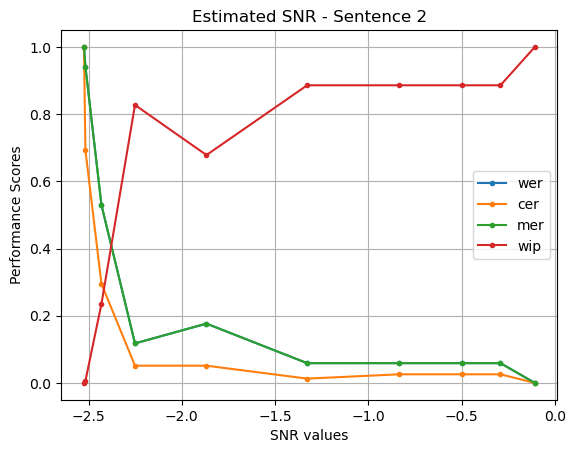

In [121]:
# Plot estimated SNR

df2 = df2.sort_values('estimated_snr', ascending = False)
ax2 = df2.plot(x='estimated_snr', y=['wer', 'cer', 'mer', 'wip'], grid=True, style='.-')
plt.title("Estimated SNR - Sentence 2")
plt.xlabel("SNR values")
plt.ylabel("Performance Scores")

Text(0, 0.5, 'Performance Scores')

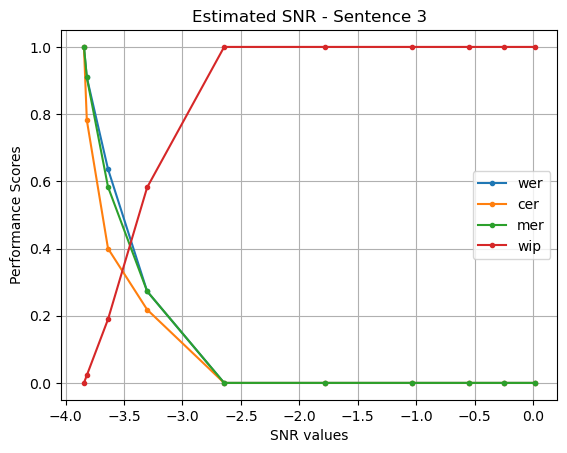

In [120]:
# Plot estimated SNR

df3 = df3.sort_values('estimated_snr', ascending = False)
ax3 = df3.plot(x='estimated_snr', y=['wer', 'cer', 'mer', 'wip'], grid=True, style='.-')
plt.title("Estimated SNR - Sentence 3")
plt.xlabel("SNR values")
plt.ylabel("Performance Scores")

Text(0, 0.5, 'Performance Scores')

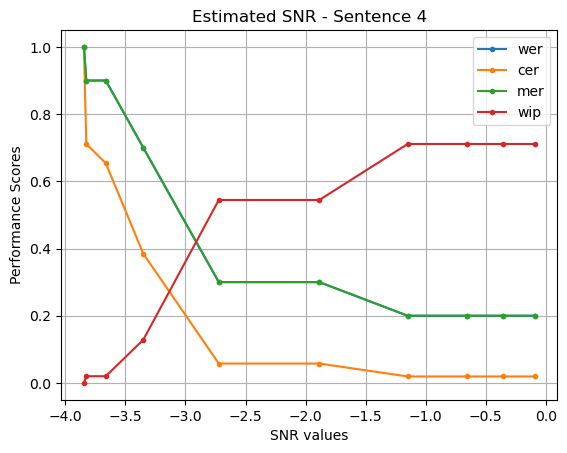

In [122]:
# Plot estimated SNR

df4 = df4.sort_values('estimated_snr', ascending = False)
ax4 = df4.plot(x='estimated_snr', y=['wer', 'cer', 'mer', 'wip'], grid=True, style='.-')
plt.title("Estimated SNR - Sentence 4")
plt.xlabel("SNR values")
plt.ylabel("Performance Scores")

Text(0, 0.5, 'Word Error Rate')

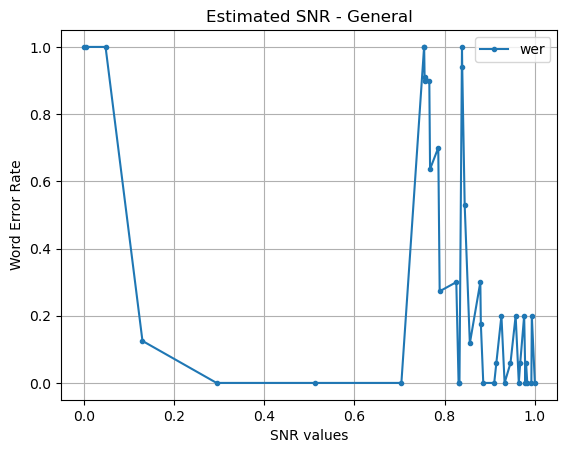

In [77]:
# Plot estimated SNR

snr_df = snr_df.sort_values('estimated_snr', ascending = False)
ax = snr_df.plot(x='estimated_snr', y=['wer'], grid=True, style='.-')
plt.title("Estimated SNR - General")
plt.xlabel("SNR values")
plt.ylabel("Word Error Rate")

Text(0, 0.5, 'Word Error Rate')

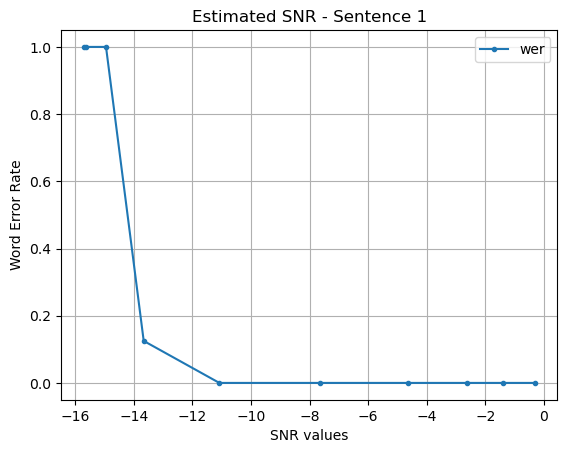

In [123]:
# Plot estimated SNR

df1 = df1.sort_values('estimated_snr', ascending = False)
ax1 = df1.plot(x='estimated_snr', y=['wer'], grid=True, style='.-')
plt.title("Estimated SNR - Sentence 1")
plt.xlabel("SNR values")
plt.ylabel("Word Error Rate")

Text(0, 0.5, 'Word Error Rate')

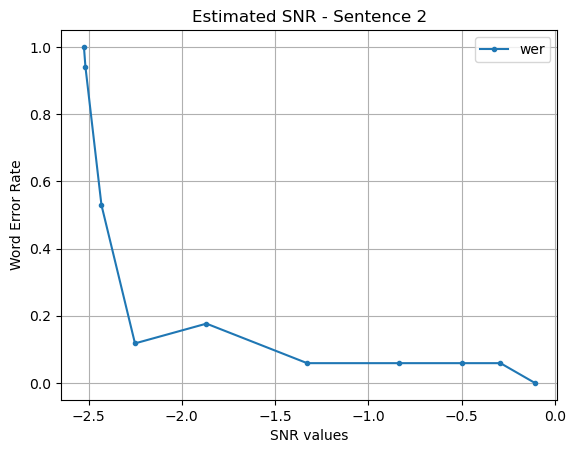

In [124]:
# Plot estimated SNR

df2 = df2.sort_values('estimated_snr', ascending = False)
ax2 = df2.plot(x='estimated_snr', y=['wer'], grid=True, style='.-')
plt.title("Estimated SNR - Sentence 2")
plt.xlabel("SNR values")
plt.ylabel("Word Error Rate")

Text(0, 0.5, 'Word Error Rate')

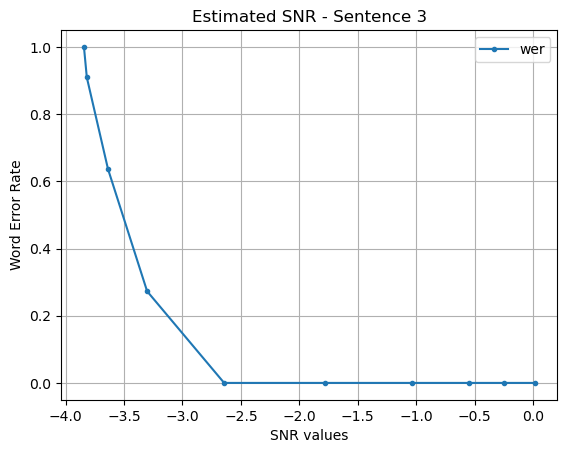

In [125]:
# Plot estimated SNR

df3 = df3.sort_values('estimated_snr', ascending = False)
ax3 = df3.plot(x='estimated_snr', y=['wer'], grid=True, style='.-')
plt.title("Estimated SNR - Sentence 3")
plt.xlabel("SNR values")
plt.ylabel("Word Error Rate")

Text(0, 0.5, 'Word Error Rate')

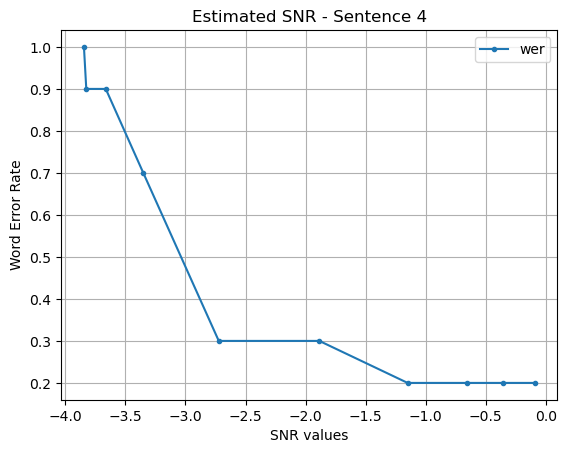

In [126]:
# Plot estimated SNR

df4 = df4.sort_values('estimated_snr', ascending = False)
ax4 = df4.plot(x='estimated_snr', y=['wer'], grid=True, style='.-')
plt.title("Estimated SNR - Sentence 4")
plt.xlabel("SNR values")
plt.ylabel("Word Error Rate")

Text(0, 0.5, 'Performance Scores')

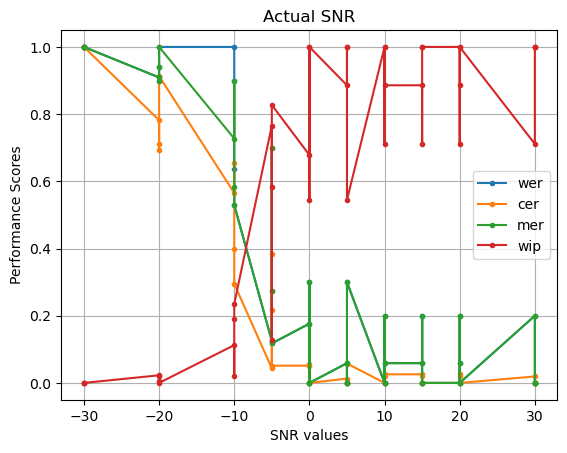

In [78]:
# Plot actual SNR

snr_df = snr_df.sort_values('snr', ascending = False)
ax = snr_df.plot(x='snr', y=['wer', 'cer', 'mer', 'wip'], grid=True, style='.-')
plt.title("Actual SNR")
plt.xlabel("SNR values")
plt.ylabel("Performance Scores")

Text(0, 0.5, 'Word Error Rate')

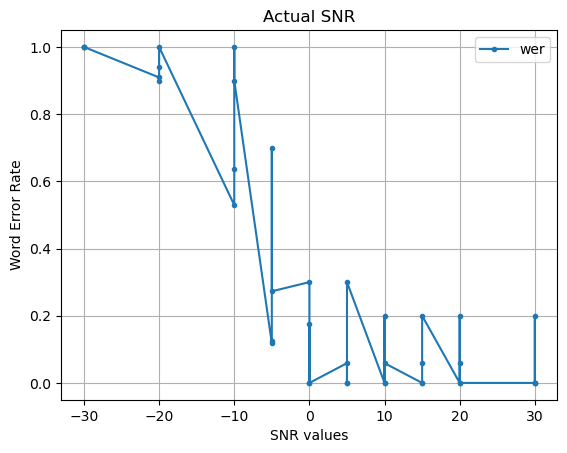

In [79]:
# Plot actual SNR

snr_df = snr_df.sort_values('snr', ascending = False)
ax = snr_df.plot(x='snr', y=['wer'], grid=True, style='.-')
plt.title("Actual SNR")
plt.xlabel("SNR values")
plt.ylabel("Word Error Rate")

Text(0, 0.5, 'Word Error Rate')

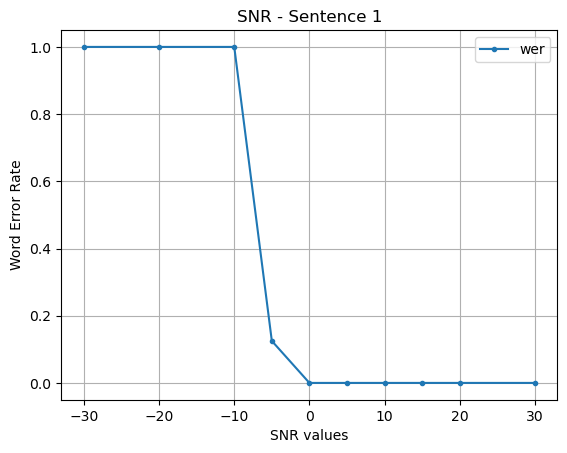

In [149]:
# Plot estimated SNR

df1 = df1.sort_values('snr', ascending = False)
ax1 = df1.plot(x='snr', y=['wer'], grid=True, style='.-')
plt.title("SNR - Sentence 1")
plt.xlabel("SNR values")
plt.ylabel("Word Error Rate")

Text(0, 0.5, 'Word Error Rate')

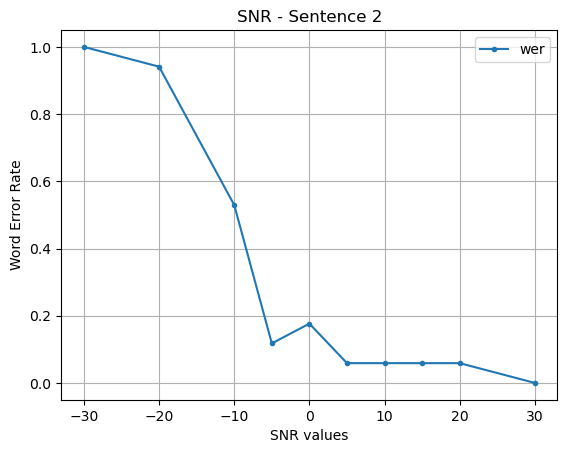

In [150]:
# Plot estimated SNR

df2 = df2.sort_values('snr', ascending = False)
ax2 = df2.plot(x='snr', y=['wer'], grid=True, style='.-')
plt.title("SNR - Sentence 2")
plt.xlabel("SNR values")
plt.ylabel("Word Error Rate")

Text(0, 0.5, 'Word Error Rate')

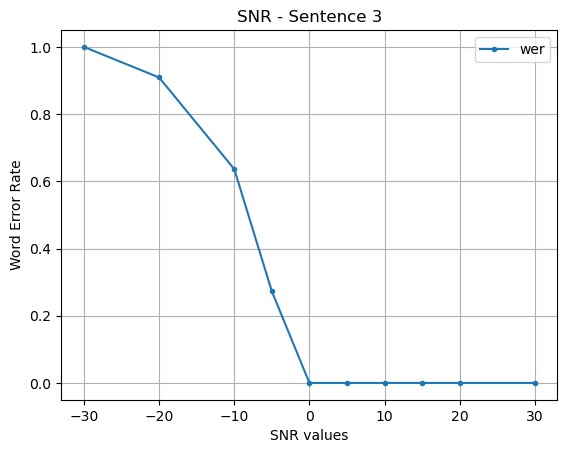

In [151]:
# Plot estimated SNR

df3 = df3.sort_values('snr', ascending = False)
ax3 = df3.plot(x='snr', y=['wer'], grid=True, style='.-')
plt.title("SNR - Sentence 3")
plt.xlabel("SNR values")
plt.ylabel("Word Error Rate")

Text(0, 0.5, 'Word Error Rate')

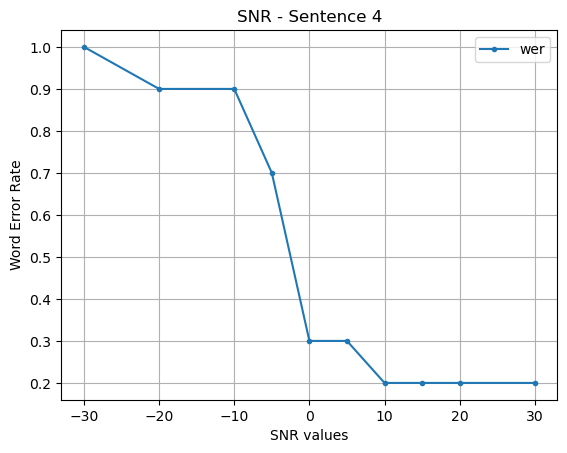

In [152]:
# Plot estimated SNR

df4 = df4.sort_values('snr', ascending = False)
ax4 = df4.plot(x='snr', y=['wer'], grid=True, style='.-')
plt.title("SNR - Sentence 4")
plt.xlabel("SNR values")
plt.ylabel("Word Error Rate")

Both plots show a similar trend, with a threshold after which the performance scores start getting somewhat acceptable. The threshold value is around -0.0026 for the estimated SNR values and 0 for the actual SNR values.